# Lab 4: Loss Functions - Interactive Demo

## Introduction

Welcome to Lab 4! In this notebook, we'll explore all the loss functions we've implemented and see them in action.

**What we'll cover:**
1. Regression losses and their properties
2. Classification losses for binary and multi-class tasks
3. Handling class imbalance
4. Label smoothing
5. Advanced losses for special tasks
6. Complete training examples

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../')

from semester1.lab2_autograd.autograd import Tensor
from semester1.lab3_activation_functions.activations import relu, sigmoid, softmax
from semester1.lab4_loss_functions.losses import *

# Set random seed for reproducibility
np.random.seed(42)

## Part 1: Regression Losses

### 1.1 Mean Squared Error (MSE)

MSE Loss: 9.1875


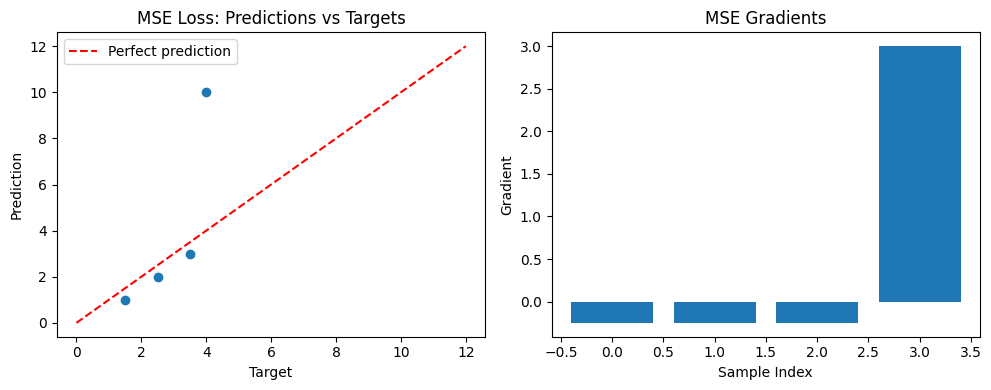

In [2]:
# Create sample predictions and targets
predictions = Tensor([1.0, 2.0, 3.0, 10.0], requires_grad=True)
targets = Tensor([1.5, 2.5, 3.5, 4.0])

# Compute MSE loss
loss = mse_loss(predictions, targets)
print(f"MSE Loss: {loss.data:.4f}")

# Visualize
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(targets.data, predictions.data)
plt.plot([0, 12], [0, 12], 'r--', label='Perfect prediction')
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.title('MSE Loss: Predictions vs Targets')
plt.legend()

# Compute gradient
loss.backward()
plt.subplot(1, 2, 2)
plt.bar(range(4), predictions.grad.data)
plt.xlabel('Sample Index')
plt.ylabel('Gradient')
plt.title('MSE Gradients')
plt.tight_layout()
plt.show()


### 1.2 Comparing MSE, MAE, and Smooth L1

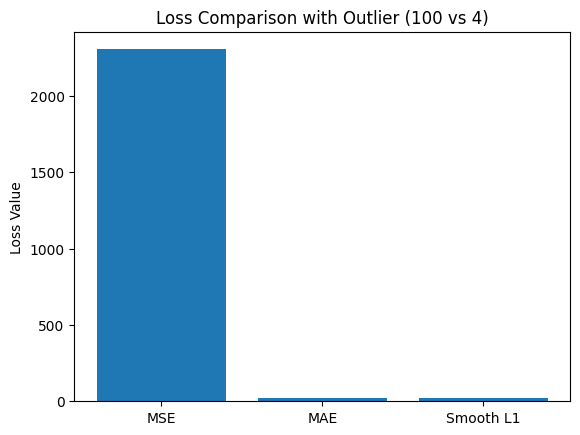


Observation: MSE is much more sensitive to the outlier!


In [3]:
# Test with outlier
predictions = Tensor([1.0, 2.0, 3.0, 100.0])
targets = Tensor([1.5, 2.5, 3.5, 4.0])

losses = {
    'MSE': mse_loss(predictions, targets),
    'MAE': mae_loss(predictions, targets),
    'Smooth L1': smooth_l1_loss(predictions, targets, beta=1.0)
}

plt.bar(losses.keys(), [l.data for l in losses.values()])
plt.ylabel('Loss Value')
plt.title('Loss Comparison with Outlier (100 vs 4)')
plt.show()

print("\nObservation: MSE is much more sensitive to the outlier!")

### 1.3 Loss Surfaces

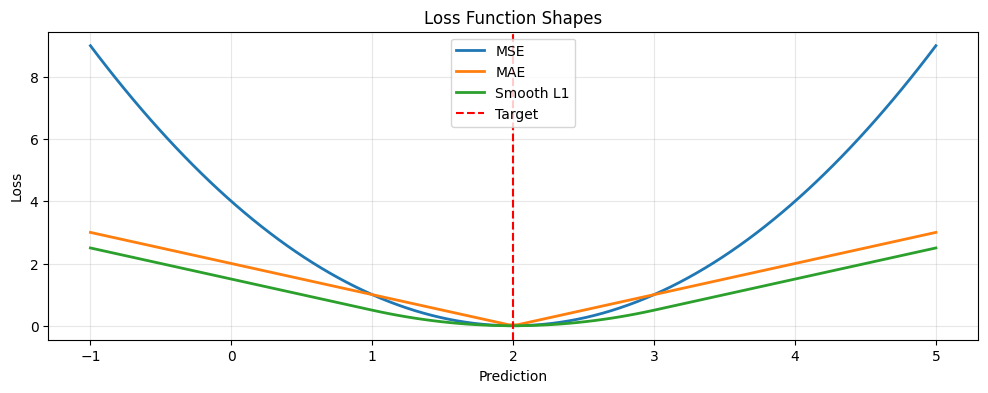

In [4]:
# Visualize loss surface for different losses
target_val = 2.0
predictions_range = np.linspace(-1, 5, 100)

mse_vals = []
mae_vals = []
smooth_l1_vals = []

for pred in predictions_range:
    pred_tensor = Tensor([pred])
    target_tensor = Tensor([target_val])
    
    mse_vals.append(mse_loss(pred_tensor, target_tensor).data)
    mae_vals.append(mae_loss(pred_tensor, target_tensor).data)
    smooth_l1_vals.append(smooth_l1_loss(pred_tensor, target_tensor, beta=1.0).data)

plt.figure(figsize=(12, 4))
plt.plot(predictions_range, mse_vals, label='MSE', linewidth=2)
plt.plot(predictions_range, mae_vals, label='MAE', linewidth=2)
plt.plot(predictions_range, smooth_l1_vals, label='Smooth L1', linewidth=2)
plt.axvline(x=target_val, color='r', linestyle='--', label='Target')
plt.xlabel('Prediction')
plt.ylabel('Loss')
plt.title('Loss Function Shapes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Part 2: Binary Classification

### 2.1 Binary Cross-Entropy

BCE Loss: 0.2310


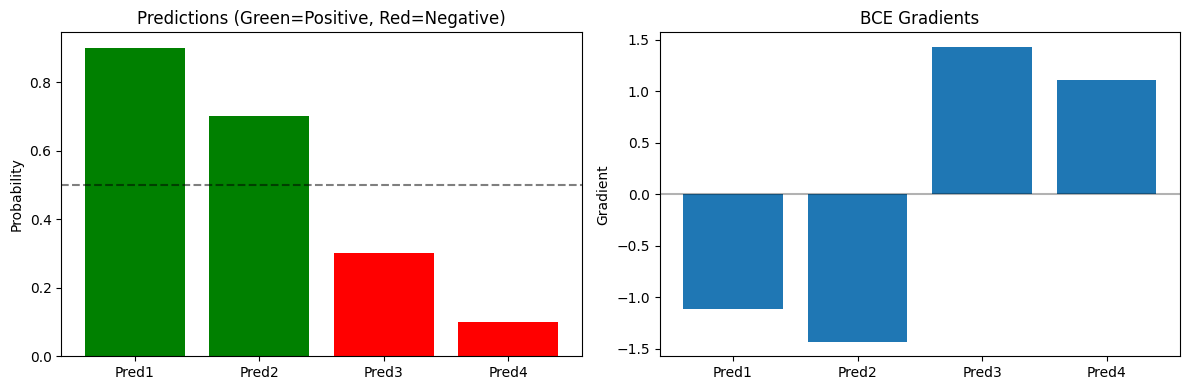

In [5]:
# Sample predictions (after sigmoid) and targets
predictions = Tensor([0.9, 0.7, 0.3, 0.1], requires_grad=True)
targets = Tensor([1.0, 1.0, 0.0, 0.0])

loss = binary_cross_entropy(predictions, targets)
print(f"BCE Loss: {loss.data:.4f}")

# Visualize
loss.backward()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(['Pred1', 'Pred2', 'Pred3', 'Pred4'], predictions.data, 
            color=['g' if t == 1 else 'r' for t in targets.data])
axes[0].set_ylabel('Probability')
axes[0].set_title('Predictions (Green=Positive, Red=Negative)')
axes[0].axhline(y=0.5, color='k', linestyle='--', alpha=0.5)

axes[1].bar(['Pred1', 'Pred2', 'Pred3', 'Pred4'], predictions.grad.data)
axes[1].set_ylabel('Gradient')
axes[1].set_title('BCE Gradients')
axes[1].axhline(y=0, color='k', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

### 2.2 BCE vs BCE with Logits

In [6]:
# Demonstrate numerical stability
logits = Tensor([100.0, -100.0], requires_grad=True)
targets = Tensor([1.0, 0.0])

# Method 1: Sigmoid + BCE (can overflow)
try:
    probs = sigmoid(logits)
    loss1 = binary_cross_entropy(probs, targets)
    print(f"Sigmoid + BCE: {loss1.data:.4f}")
except:
    print("Sigmoid + BCE: Numerical issues!")

# Method 2: BCE with Logits (stable)
loss2 = binary_cross_entropy_with_logits(logits, targets)
print(f"BCE with Logits: {loss2.data:.4f}")
print("\nConclusion: Always use BCE with Logits for stability!")

Sigmoid + BCE: 0.0000
BCE with Logits: 0.0000

Conclusion: Always use BCE with Logits for stability!



## Part 3: Multi-Class Classification

### 3.1 Cross-Entropy Loss

Cross-Entropy Loss: 1.3633
Accuracy: 28.00%


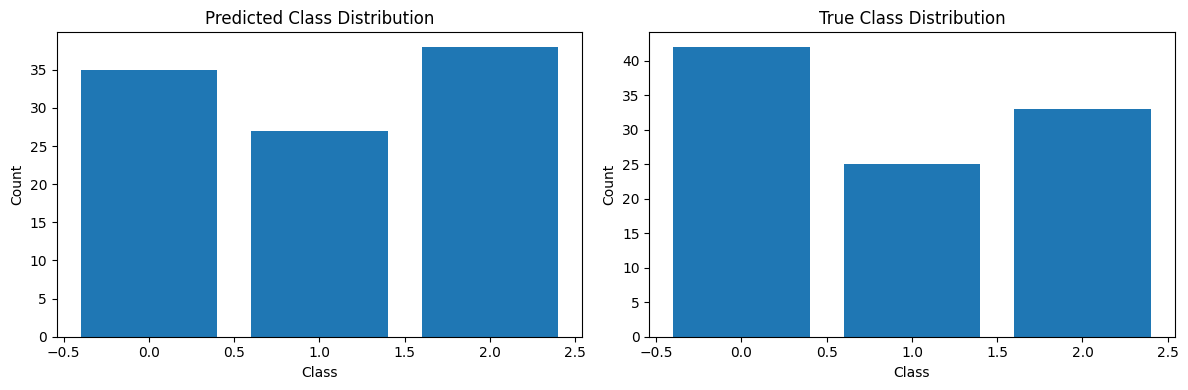

In [7]:
# Create synthetic 3-class problem
num_samples = 100
num_classes = 3

# Generate random logits
logits = Tensor(np.random.randn(num_samples, num_classes), requires_grad=True)
targets = Tensor(np.random.randint(0, num_classes, num_samples))

# Compute loss
loss = cross_entropy_loss(logits, targets)
print(f"Cross-Entropy Loss: {loss.data:.4f}")

# Compute accuracy
probs = softmax(logits, axis=1)
predictions = np.argmax(probs.data, axis=1)
accuracy = np.mean(predictions == targets.data)
print(f"Accuracy: {accuracy*100:.2f}%")

# Visualize confusion
from collections import Counter
pred_counts = Counter(predictions)
target_counts = Counter(targets.data.astype(int))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(pred_counts.keys(), pred_counts.values())
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_title('Predicted Class Distribution')

axes[1].bar(target_counts.keys(), target_counts.values())
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_title('True Class Distribution')

plt.tight_layout()
plt.show()

### 3.2 Label Smoothing Effect

Loss without smoothing: 0.0001
Loss with smoothing: 0.6668


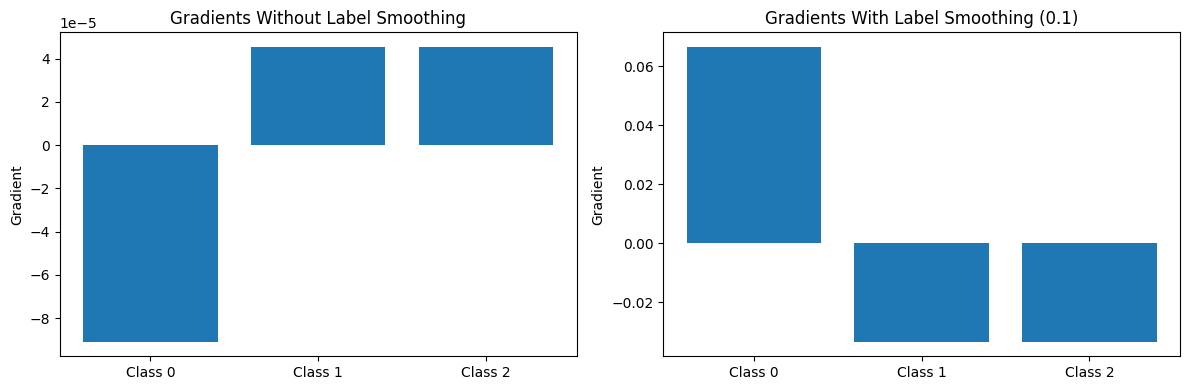


Observation: Smoothing prevents overconfidence!


In [8]:
logits = Tensor([[10.0, 0.0, 0.0]], requires_grad=True)
targets = Tensor([0])

# Without smoothing
loss_no_smooth = cross_entropy_loss(logits, targets, label_smoothing=0.0)
logits.zero_grad()
loss_no_smooth.backward()
grad_no_smooth = logits.grad.data.copy()

# With smoothing
logits_smooth = Tensor([[10.0, 0.0, 0.0]], requires_grad=True)
loss_smooth = cross_entropy_loss(logits_smooth, targets, label_smoothing=0.1)
loss_smooth.backward()
grad_smooth = logits_smooth.grad.data.copy()

print(f"Loss without smoothing: {loss_no_smooth.data:.4f}")
print(f"Loss with smoothing: {loss_smooth.data:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(['Class 0', 'Class 1', 'Class 2'], grad_no_smooth[0])
axes[0].set_ylabel('Gradient')
axes[0].set_title('Gradients Without Label Smoothing')

axes[1].bar(['Class 0', 'Class 1', 'Class 2'], grad_smooth[0])
axes[1].set_ylabel('Gradient')
axes[1].set_title('Gradients With Label Smoothing (0.1)')

plt.tight_layout()
plt.show()

print("\nObservation: Smoothing prevents overconfidence!")

## Part 4: Handling Class Imbalance

### 4.1 Imbalanced Dataset Problem

In [9]:
# Create highly imbalanced dataset
# 95% class 0, 5% class 1
n_majority = 950
n_minority = 50
targets_imbalanced = np.array([0]*n_majority + [1]*n_minority)

print(f"Class distribution:")
print(f"  Class 0: {n_majority} samples ({n_majority/1000*100}%)")
print(f"  Class 1: {n_minority} samples ({n_minority/1000*100}%)")

# Generate predictions (model predicting mostly class 0)
logits_imbalanced = Tensor(np.random.randn(1000, 2))
logits_imbalanced.data[:, 0] += 2  # Bias towards class 0

# Loss without weights
loss_no_weight = cross_entropy_loss(
    logits_imbalanced, 
    Tensor(targets_imbalanced)
)
print(f"\nLoss without weights: {loss_no_weight.data:.4f}")

Class distribution:
  Class 0: 950 samples (95.0%)
  Class 1: 50 samples (5.0%)

Loss without weights: 0.3452


### 4.2 Using Class Weights


Computed class weights:
  Class 0: 0.5263
  Class 1: 10.0000

Loss with weights: 1.1964


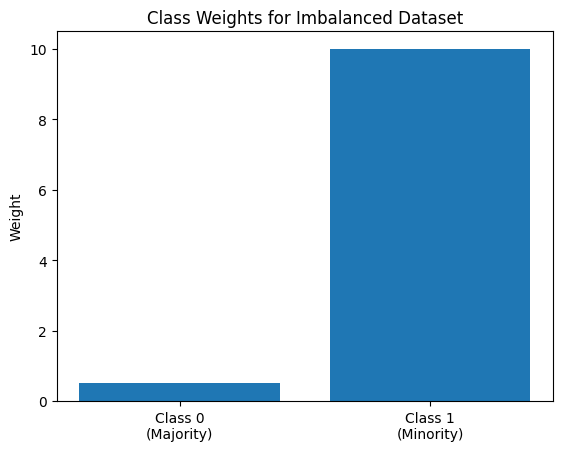


Conclusion: Minority class gets higher weight!


In [10]:
# Compute balanced weights
weights = compute_class_weights(targets_imbalanced, num_classes=2, method='balanced')
print(f"\nComputed class weights:")
print(f"  Class 0: {weights[0]:.4f}")
print(f"  Class 1: {weights[1]:.4f}")

# Loss with weights
loss_with_weight = cross_entropy_loss(
    logits_imbalanced,
    Tensor(targets_imbalanced),
    weight=Tensor(weights)
)
print(f"\nLoss with weights: {loss_with_weight.data:.4f}")

# Visualize weights
plt.bar(['Class 0\n(Majority)', 'Class 1\n(Minority)'], weights)
plt.ylabel('Weight')
plt.title('Class Weights for Imbalanced Dataset')
plt.show()

print("\nConclusion: Minority class gets higher weight!")

### 4.3 Focal Loss for Imbalance

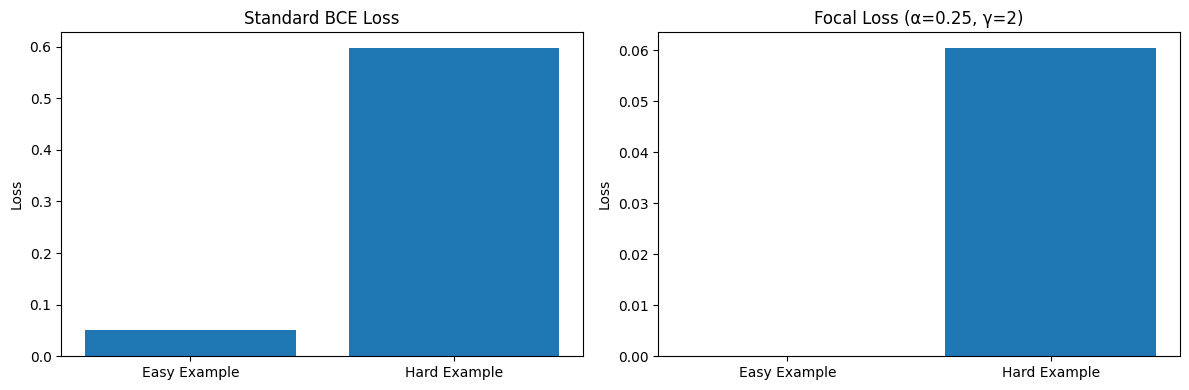

Focal Loss focuses more on hard examples!


In [11]:
# Easy vs Hard examples
easy_pred = Tensor([[0.95, 0.05]])  # Confident correct prediction
hard_pred = Tensor([[0.55, 0.45]])  # Less confident correct prediction
target = Tensor([[1.0, 0.0]])

# Standard BCE
bce_easy = binary_cross_entropy(easy_pred, target)
bce_hard = binary_cross_entropy(hard_pred, target)

# Focal Loss
focal_easy = focal_loss(easy_pred, target, alpha=0.25, gamma=2.0)
focal_hard = focal_loss(hard_pred, target, alpha=0.25, gamma=2.0)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(['Easy Example', 'Hard Example'], 
            [bce_easy.data, bce_hard.data])
axes[0].set_ylabel('Loss')
axes[0].set_title('Standard BCE Loss')

axes[1].bar(['Easy Example', 'Hard Example'],
            [focal_easy.data, focal_hard.data])
axes[1].set_ylabel('Loss')
axes[1].set_title('Focal Loss (α=0.25, γ=2)')

plt.tight_layout()
plt.show()

print("Focal Loss focuses more on hard examples!")


## Part 5: Complete Training Examples

### 5.1 Linear Regression with MSE

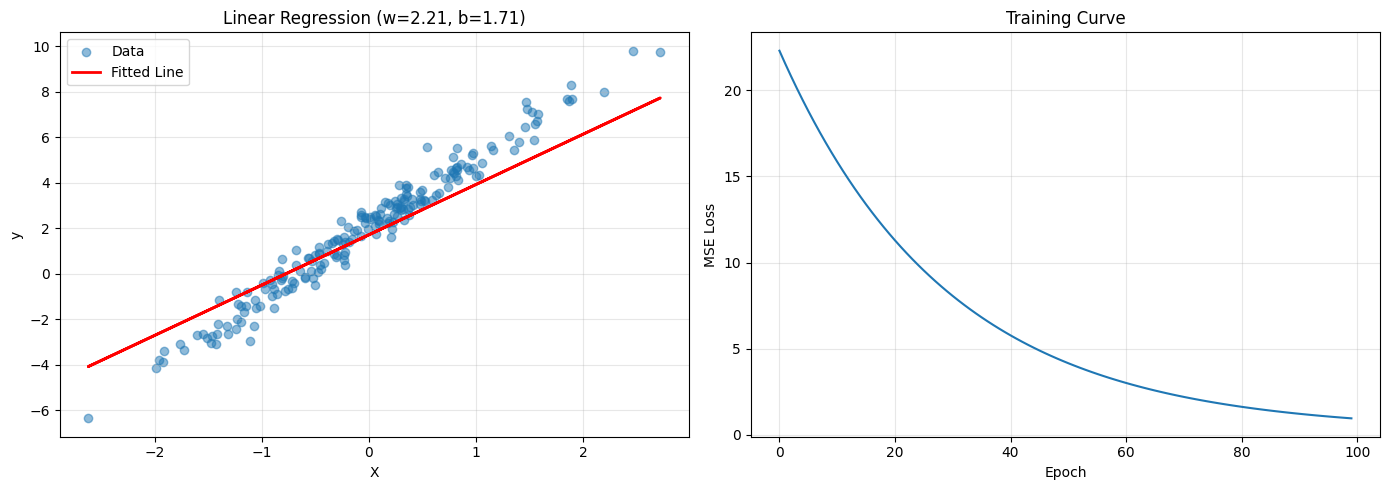

True parameters: w=3.0, b=2.0
Learned parameters: w=2.21, b=1.71


In [12]:
# Generate synthetic regression data
np.random.seed(42)
X_data = np.random.randn(200, 1)
y_data = 3 * X_data + 2 + np.random.randn(200, 1) * 0.5

X = Tensor(X_data)
y = Tensor(y_data)

# Initialize parameters
w = Tensor(np.random.randn(1, 1), requires_grad=True)
b = Tensor(np.zeros((1, 1)), requires_grad=True)

# Training
losses = []
learning_rate = 0.01

for epoch in range(100):
    # Forward
    y_pred = X @ w + b
    loss = mse_loss(y_pred, y)
    losses.append(loss.data)
    
    # Backward
    w.zero_grad()
    b.zero_grad()
    loss.backward()
    
    # Update
    w.data -= learning_rate * w.grad.data
    b.data -= learning_rate * b.grad.data

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(X_data, y_data, alpha=0.5, label='Data')
axes[0].plot(X_data, X_data * w.data[0,0] + b.data[0,0], 
             'r-', linewidth=2, label='Fitted Line')
axes[0].set_xlabel('X')
axes[0].set_ylabel('y')
axes[0].set_title(f'Linear Regression (w={w.data[0,0]:.2f}, b={b.data[0,0]:.2f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(losses)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MSE Loss')
axes[1].set_title('Training Curve')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"True parameters: w=3.0, b=2.0")
print(f"Learned parameters: w={w.data[0,0]:.2f}, b={b.data[0,0]:.2f}")

### 5.2 Binary Classification with BCE

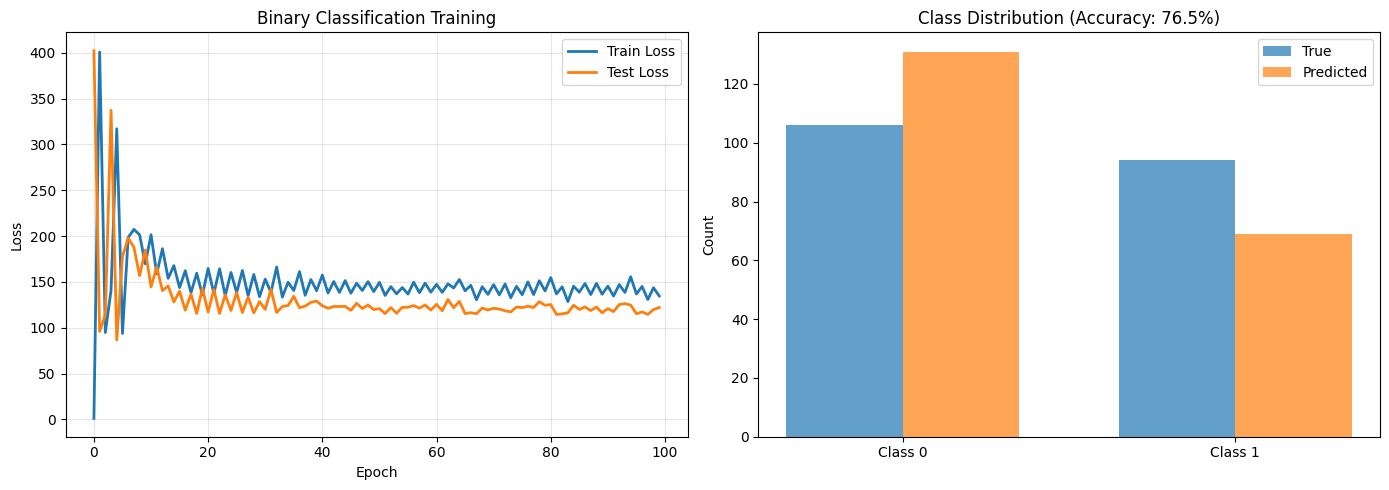


Final Test Accuracy: 76.50%
Final Train Loss: 134.6475
Final Test Loss: 122.0974


In [13]:
# Generate synthetic binary classification data
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X_data, y_data = make_classification(
    n_samples=1000, n_features=20, n_informative=15,
    n_redundant=5, n_classes=2, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42
)

# Convert to tensors
X_train_t = Tensor(X_train.astype(np.float32))
y_train_t = Tensor(y_train.astype(np.float32))
X_test_t = Tensor(X_test.astype(np.float32))
y_test_t = Tensor(y_test.astype(np.float32))

# Initialize model
W = Tensor(np.random.randn(20, 1) * 0.1, requires_grad=True)
b = Tensor(np.zeros((1, 1)), requires_grad=True)

# Training
train_losses = []
test_losses = []
learning_rate = 0.1

for epoch in range(100):
    # Forward
    logits_train = X_train_t @ W + b
    loss_train = binary_cross_entropy_with_logits(
        logits_train.reshape(-1), y_train_t
    )
    train_losses.append(loss_train.data)
    
    # Backward
    W.zero_grad()
    b.zero_grad()
    loss_train.backward()
    
    # Update
    W.data -= learning_rate * W.grad.data
    b.data -= learning_rate * b.grad.data
    
    # Test loss
    logits_test = X_test_t @ W + b
    loss_test = binary_cross_entropy_with_logits(
        logits_test.reshape(-1), y_test_t
    )
    test_losses.append(loss_test.data)

# Compute final accuracy
logits_test_final = X_test_t @ W + b
probs_test = sigmoid(logits_test_final)
predictions = (probs_test.data > 0.5).astype(int).flatten()
accuracy = np.mean(predictions == y_test)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(test_losses, label='Test Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Binary Classification Training')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Confusion matrix-like visualization
from collections import Counter
pred_counts = Counter(predictions)
true_counts = Counter(y_test)

x_pos = np.arange(2)
width = 0.35
axes[1].bar(x_pos - width/2, [true_counts[0], true_counts[1]], 
            width, label='True', alpha=0.7)
axes[1].bar(x_pos + width/2, [pred_counts[0], pred_counts[1]], 
            width, label='Predicted', alpha=0.7)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(['Class 0', 'Class 1'])
axes[1].set_ylabel('Count')
axes[1].set_title(f'Class Distribution (Accuracy: {accuracy*100:.1f}%)')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nFinal Test Accuracy: {accuracy*100:.2f}%")
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")

### 5.3 Multi-Class Classification

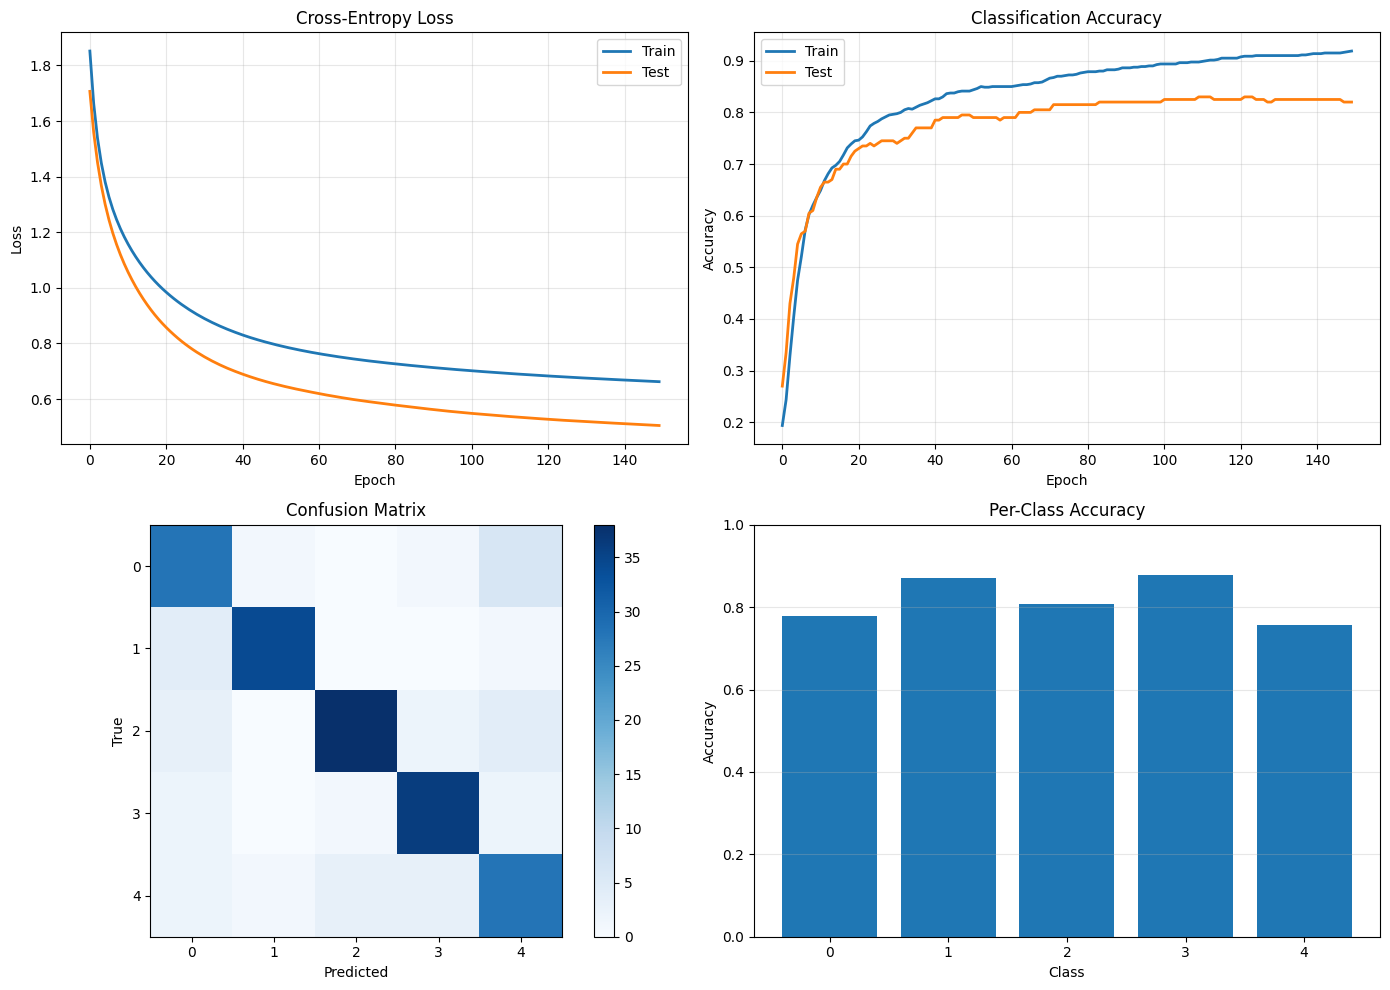


Final Results:
Train Accuracy: 91.88%
Test Accuracy: 82.00%
Train Loss: 0.6624
Test Loss: 0.5048


In [14]:
# Generate multi-class data
from sklearn.datasets import make_classification

X_data, y_data = make_classification(
    n_samples=1000, n_features=20, n_informative=15,
    n_redundant=5, n_classes=5, n_clusters_per_class=1,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42
)

# Convert to tensors
X_train_t = Tensor(X_train.astype(np.float32))
y_train_t = Tensor(y_train)
X_test_t = Tensor(X_test.astype(np.float32))
y_test_t = Tensor(y_test)

# Initialize 2-layer network
W1 = Tensor(np.random.randn(20, 32) * 0.1, requires_grad=True)
b1 = Tensor(np.zeros((1, 32)), requires_grad=True)
W2 = Tensor(np.random.randn(32, 5) * 0.1, requires_grad=True)
b2 = Tensor(np.zeros((1, 5)), requires_grad=True)

# Training
train_losses = []
test_losses = []
train_accs = []
test_accs = []
learning_rate = 0.1

for epoch in range(150):
    # Forward
    h1 = relu(X_train_t @ W1 + b1)
    logits = h1 @ W2 + b2
    loss = cross_entropy_loss(logits, y_train_t, label_smoothing=0.1)
    train_losses.append(loss.data)
    
    # Backward
    W1.zero_grad()
    b1.zero_grad()
    W2.zero_grad()
    b2.zero_grad()
    loss.backward()
    
    # Update
    W1.data -= learning_rate * W1.grad.data
    b1.data -= learning_rate * b1.grad.data
    W2.data -= learning_rate * W2.grad.data
    b2.data -= learning_rate * b2.grad.data
    
    # Compute accuracies
    probs_train = softmax(logits, axis=1)
    pred_train = np.argmax(probs_train.data, axis=1)
    train_accs.append(np.mean(pred_train == y_train))
    
    # Test
    h1_test = relu(X_test_t @ W1 + b1)
    logits_test = h1_test @ W2 + b2
    loss_test = cross_entropy_loss(logits_test, y_test_t)
    test_losses.append(loss_test.data)
    
    probs_test = softmax(logits_test, axis=1)
    pred_test = np.argmax(probs_test.data, axis=1)
    test_accs.append(np.mean(pred_test == y_test))

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss curves
axes[0, 0].plot(train_losses, label='Train', linewidth=2)
axes[0, 0].plot(test_losses, label='Test', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Cross-Entropy Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy curves
axes[0, 1].plot(train_accs, label='Train', linewidth=2)
axes[0, 1].plot(test_accs, label='Test', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Classification Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_test)
im = axes[1, 0].imshow(cm, cmap='Blues')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('True')
axes[1, 0].set_title('Confusion Matrix')
plt.colorbar(im, ax=axes[1, 0])

# Class-wise accuracy
class_accs = []
for c in range(5):
    mask = y_test == c
    if mask.sum() > 0:
        class_acc = np.mean(pred_test[mask] == y_test[mask])
        class_accs.append(class_acc)
    else:
        class_accs.append(0)

axes[1, 1].bar(range(5), class_accs)
axes[1, 1].set_xlabel('Class')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Per-Class Accuracy')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nFinal Results:")
print(f"Train Accuracy: {train_accs[-1]*100:.2f}%")
print(f"Test Accuracy: {test_accs[-1]*100:.2f}%")
print(f"Train Loss: {train_losses[-1]:.4f}")
print(f"Test Loss: {test_losses[-1]:.4f}")

## Part 6: Advanced Losses

### 6.1 Hinge Loss for SVM

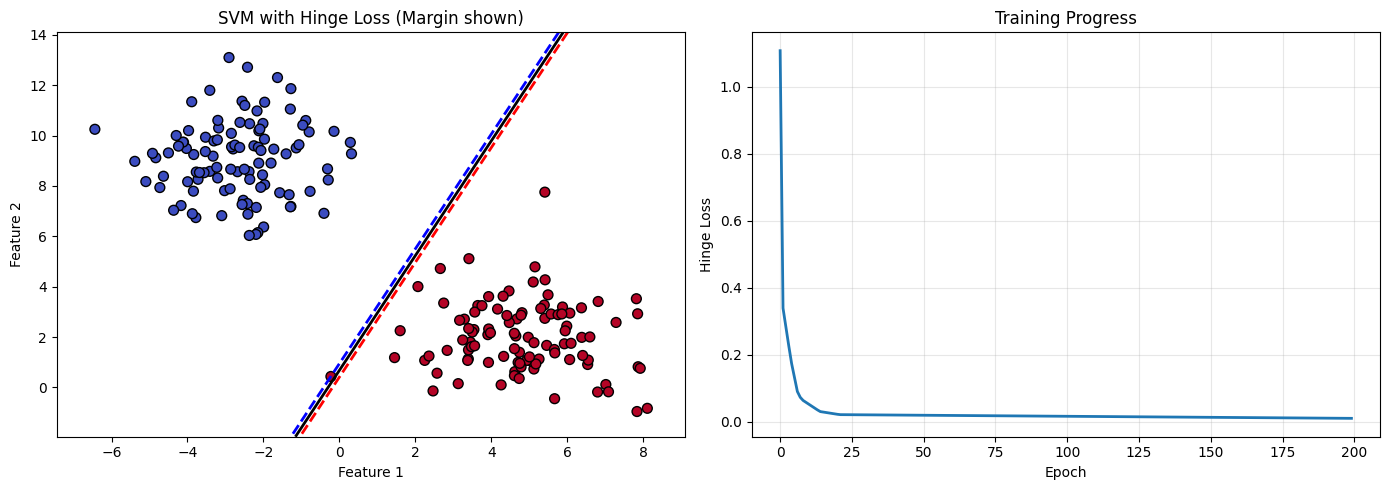

Final Loss: 0.0100


In [15]:
# Generate linearly separable data
from sklearn.datasets import make_blobs

X_data, y_data = make_blobs(n_samples=200, centers=2, n_features=2, 
                             cluster_std=1.5, random_state=42)
y_data = 2 * y_data - 1  # Convert to {-1, +1}

X = Tensor(X_data.astype(np.float32))
y = Tensor(y_data.astype(np.float32))

# Initialize parameters
W = Tensor(np.random.randn(2, 1) * 0.1, requires_grad=True)
b = Tensor(np.zeros((1, 1)), requires_grad=True)

# Training with Hinge Loss
losses = []
learning_rate = 0.01

for epoch in range(200):
    # Forward
    scores = (X @ W + b).reshape(-1)
    loss = hinge_loss(scores, y, margin=1.0)
    losses.append(loss.data)
    
    # Backward
    W.zero_grad()
    b.zero_grad()
    loss.backward()
    
    # Update
    W.data -= learning_rate * W.grad.data
    b.data -= learning_rate * b.grad.data

# Visualize decision boundary
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Decision boundary
x_min, x_max = X_data[:, 0].min() - 1, X_data[:, 0].max() + 1
y_min, y_max = X_data[:, 1].min() - 1, X_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
Z = (np.c_[xx.ravel(), yy.ravel()] @ W.data + b.data).reshape(xx.shape)

axes[0].contour(xx, yy, Z, levels=[-1, 0, 1], colors=['b', 'k', 'r'],
                linestyles=['--', '-', '--'], linewidths=[2, 2, 2])
axes[0].scatter(X_data[:, 0], X_data[:, 1], c=y_data, cmap='coolwarm',
                edgecolors='k', s=50)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].set_title('SVM with Hinge Loss (Margin shown)')

axes[1].plot(losses, linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Hinge Loss')
axes[1].set_title('Training Progress')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Loss: {losses[-1]:.4f}")

### 6.2 Dice Loss for Segmentation

In [16]:
# Simulate segmentation task
np.random.seed(42)

# Generate synthetic masks
def generate_mask(size=64):
    mask = np.zeros((size, size))
    center = size // 2
    radius = size // 4
    y, x = np.ogrid[:size, :size]
    circle = (x - center)**2 + (y - center)**2 <= radius**2
    mask[circle] = 1
    return mask

# True mask
true_mask = generate_mask(64)

# Noisy prediction
pred_mask = true_mask + np.random.randn(64, 64) * 0.2
pred_mask = np.clip(pred_mask, 0, 1)

# Compute Dice loss
pred_t = Tensor(pred_mask.flatten())
true_t = Tensor(true_mask.flatten())
dice = dice_loss(pred_t, true_t, smooth=1.0)

print(f"Dice Loss: {dice.data:.4f}")
print(f"Dice Coefficient: {1 - dice.data:.4f}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(true_mask, cmap='gray')
axes[0].set_title('True Mask')
axes[0].axis('off')

axes[1].imshow(pred_mask, cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

axes[2].imshow(np.abs(true_mask - pred_mask), cmap='hot')
axes[2].set_title('Absolute Difference')
axes[2].axis('off')

plt.tight_layout()
plt.show()

TypeError: unsupported format string passed to numpy.ndarray.__format__

### 6.3 Contrastive Loss for Siamese Networks

Contrastive Loss: 0.0956

Average distance for similar pairs: 0.6032
Average distance for dissimilar pairs: 16.1660


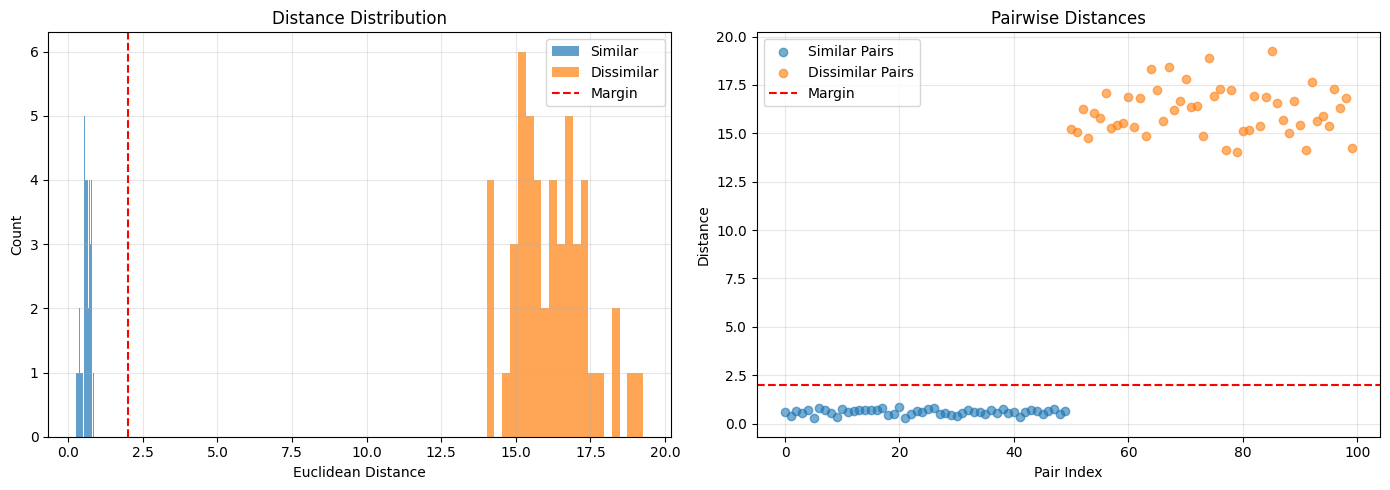

In [17]:
# Generate pairs of similar and dissimilar examples
np.random.seed(42)

# Similar pairs (same class, close in space)
n_similar = 50
similar_pairs_1 = np.random.randn(n_similar, 10)
similar_pairs_2 = similar_pairs_1 + np.random.randn(n_similar, 10) * 0.2
similar_labels = np.zeros(n_similar)  # 0 = similar

# Dissimilar pairs (different classes, far in space)
n_dissimilar = 50
dissimilar_pairs_1 = np.random.randn(n_dissimilar, 10)
dissimilar_pairs_2 = np.random.randn(n_dissimilar, 10) + 5
dissimilar_labels = np.ones(n_dissimilar)  # 1 = dissimilar

# Combine
input1 = np.vstack([similar_pairs_1, dissimilar_pairs_1])
input2 = np.vstack([similar_pairs_2, dissimilar_pairs_2])
labels = np.concatenate([similar_labels, dissimilar_labels])

# Compute contrastive loss
input1_t = Tensor(input1.astype(np.float32))
input2_t = Tensor(input2.astype(np.float32))
labels_t = Tensor(labels.astype(np.float32))

loss = contrastive_loss(input1_t, input2_t, labels_t, margin=2.0)

# Compute distances
distances = np.sqrt(np.sum((input1 - input2)**2, axis=1))

print(f"Contrastive Loss: {loss.data:.4f}")
print(f"\nAverage distance for similar pairs: {distances[:n_similar].mean():.4f}")
print(f"Average distance for dissimilar pairs: {distances[n_similar:].mean():.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(distances[:n_similar], bins=20, alpha=0.7, label='Similar')
axes[0].hist(distances[n_similar:], bins=20, alpha=0.7, label='Dissimilar')
axes[0].axvline(x=2.0, color='r', linestyle='--', label='Margin')
axes[0].set_xlabel('Euclidean Distance')
axes[0].set_ylabel('Count')
axes[0].set_title('Distance Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(range(n_similar), distances[:n_similar], 
                label='Similar Pairs', alpha=0.6)
axes[1].scatter(range(n_similar, n_similar+n_dissimilar), 
                distances[n_similar:], label='Dissimilar Pairs', alpha=0.6)
axes[1].axhline(y=2.0, color='r', linestyle='--', label='Margin')
axes[1].set_xlabel('Pair Index')
axes[1].set_ylabel('Distance')
axes[1].set_title('Pairwise Distances')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 7: Loss Landscape Visualization

### 7.1 2D Loss Landscape

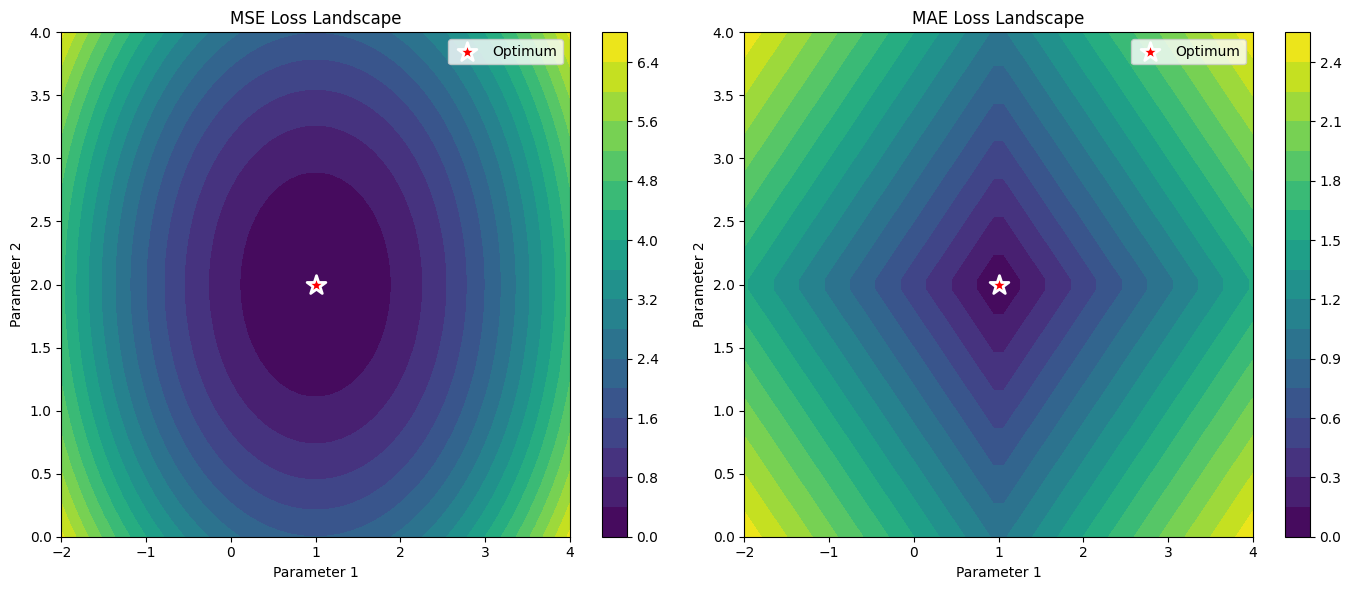

Observation: MSE creates smoother, more convex landscape


In [18]:
# Create simple 2D optimization landscape
def compute_loss_landscape(loss_fn, target, x_range, y_range, resolution=50):
    x = np.linspace(x_range[0], x_range[1], resolution)
    y = np.linspace(y_range[0], y_range[1], resolution)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    
    for i in range(resolution):
        for j in range(resolution):
            pred = Tensor([[X[i, j], Y[i, j]]])
            Z[i, j] = loss_fn(pred, target).data
    
    return X, Y, Z

# Target
target = Tensor([[1.0, 2.0]])

# Compute landscapes for different losses
X, Y, Z_mse = compute_loss_landscape(
    lambda p, t: mse_loss(p, t), target, (-2, 4), (0, 4)
)
X, Y, Z_mae = compute_loss_landscape(
    lambda p, t: mae_loss(p, t), target, (-2, 4), (0, 4)
)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

contour1 = axes[0].contourf(X, Y, Z_mse, levels=20, cmap='viridis')
axes[0].scatter([1.0], [2.0], c='r', s=200, marker='*', 
                edgecolors='white', linewidths=2, label='Optimum')
axes[0].set_xlabel('Parameter 1')
axes[0].set_ylabel('Parameter 2')
axes[0].set_title('MSE Loss Landscape')
axes[0].legend()
plt.colorbar(contour1, ax=axes[0])

contour2 = axes[1].contourf(X, Y, Z_mae, levels=20, cmap='viridis')
axes[1].scatter([1.0], [2.0], c='r', s=200, marker='*',
                edgecolors='white', linewidths=2, label='Optimum')
axes[1].set_xlabel('Parameter 1')
axes[1].set_ylabel('Parameter 2')
axes[1].set_title('MAE Loss Landscape')
axes[1].legend()
plt.colorbar(contour2, ax=axes[1])

plt.tight_layout()
plt.show()

print("Observation: MSE creates smoother, more convex landscape")

### 7.2 Optimization Path Visualization

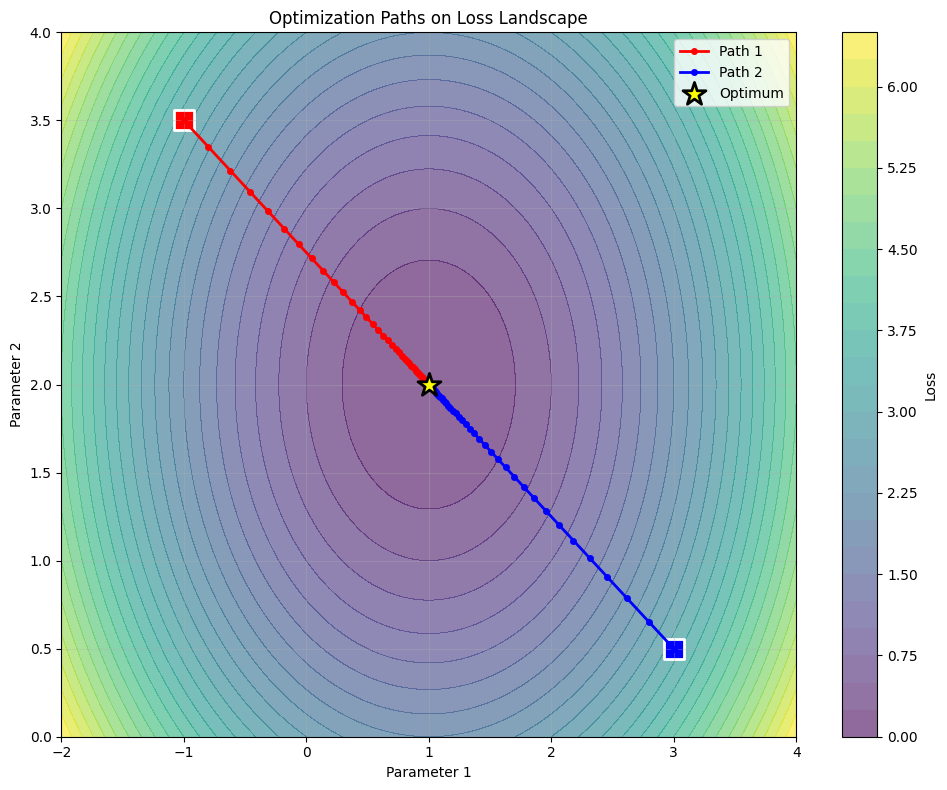

In [19]:
# Visualize optimization trajectory
target = Tensor([[1.0, 2.0]])

# Initialize at different starting points
start_points = [
    Tensor([[-1.0, 3.5]], requires_grad=True),
    Tensor([[3.0, 0.5]], requires_grad=True)
]

trajectories = []
learning_rate = 0.1

for start_param in start_points:
    trajectory = [start_param.data.copy()]
    param = Tensor(start_param.data.copy(), requires_grad=True)
    
    for _ in range(50):
        loss = mse_loss(param, target)
        param.zero_grad()
        loss.backward()
        param.data -= learning_rate * param.grad.data
        trajectory.append(param.data.copy())
    
    trajectories.append(np.array(trajectory).squeeze())

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Loss landscape
X, Y, Z = compute_loss_landscape(
    lambda p, t: mse_loss(p, t), target, (-2, 4), (0, 4), resolution=100
)
contour = ax.contourf(X, Y, Z, levels=30, cmap='viridis', alpha=0.6)
plt.colorbar(contour, ax=ax, label='Loss')

# Plot trajectories
colors = ['red', 'blue']
for i, traj in enumerate(trajectories):
    ax.plot(traj[:, 0], traj[:, 1], 'o-', color=colors[i], 
            linewidth=2, markersize=4, label=f'Path {i+1}')
    ax.scatter(traj[0, 0], traj[0, 1], c=colors[i], s=200, 
               marker='s', edgecolors='white', linewidths=2)

ax.scatter([1.0], [2.0], c='yellow', s=300, marker='*',
           edgecolors='black', linewidths=2, label='Optimum', zorder=10)
ax.set_xlabel('Parameter 1')
ax.set_ylabel('Parameter 2')
ax.set_title('Optimization Paths on Loss Landscape')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()